# Assignment 3
---
Submitted by: 

| Name  | Banner ID |
| ------------- | ------------- |
| Gaganpreet Singh  | B00819217  |
| Shruthi Kalasapura Ramesh  | B00822766  |

The Code and the ouput files for this assignment are present on [GitLab](https://git.cs.dal.ca/singh1/a3-data-science/blob/master/)

### Importing libraries and provided dataset.

In [1]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import shapely
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas

In [2]:
df=pd.read_csv('/Users/gaganpree99/Desktop/DataScience/A3/AISData.csv')

df.rename(columns={'location.coordinates.0':'x','location.coordinates.1':'y'},
          inplace=True)

gdf = gpd.GeoDataFrame(df.drop(['x', 'y'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=[shapely.geometry.Point(xy) for xy in zip(df.x, df.y)])


Analyzing GeoDataframe for the AIS data

In [3]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 766671 entries, 0 to 766670
Data columns (total 7 columns):
Unnamed: 0           766671 non-null int64
event_time           766671 non-null object
position_accuracy    697295 non-null float64
mmsi                 766671 non-null int64
sog                  697295 non-null float64
cog                  697295 non-null float64
geometry             766671 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 40.9+ MB


Plot for AIS Data:

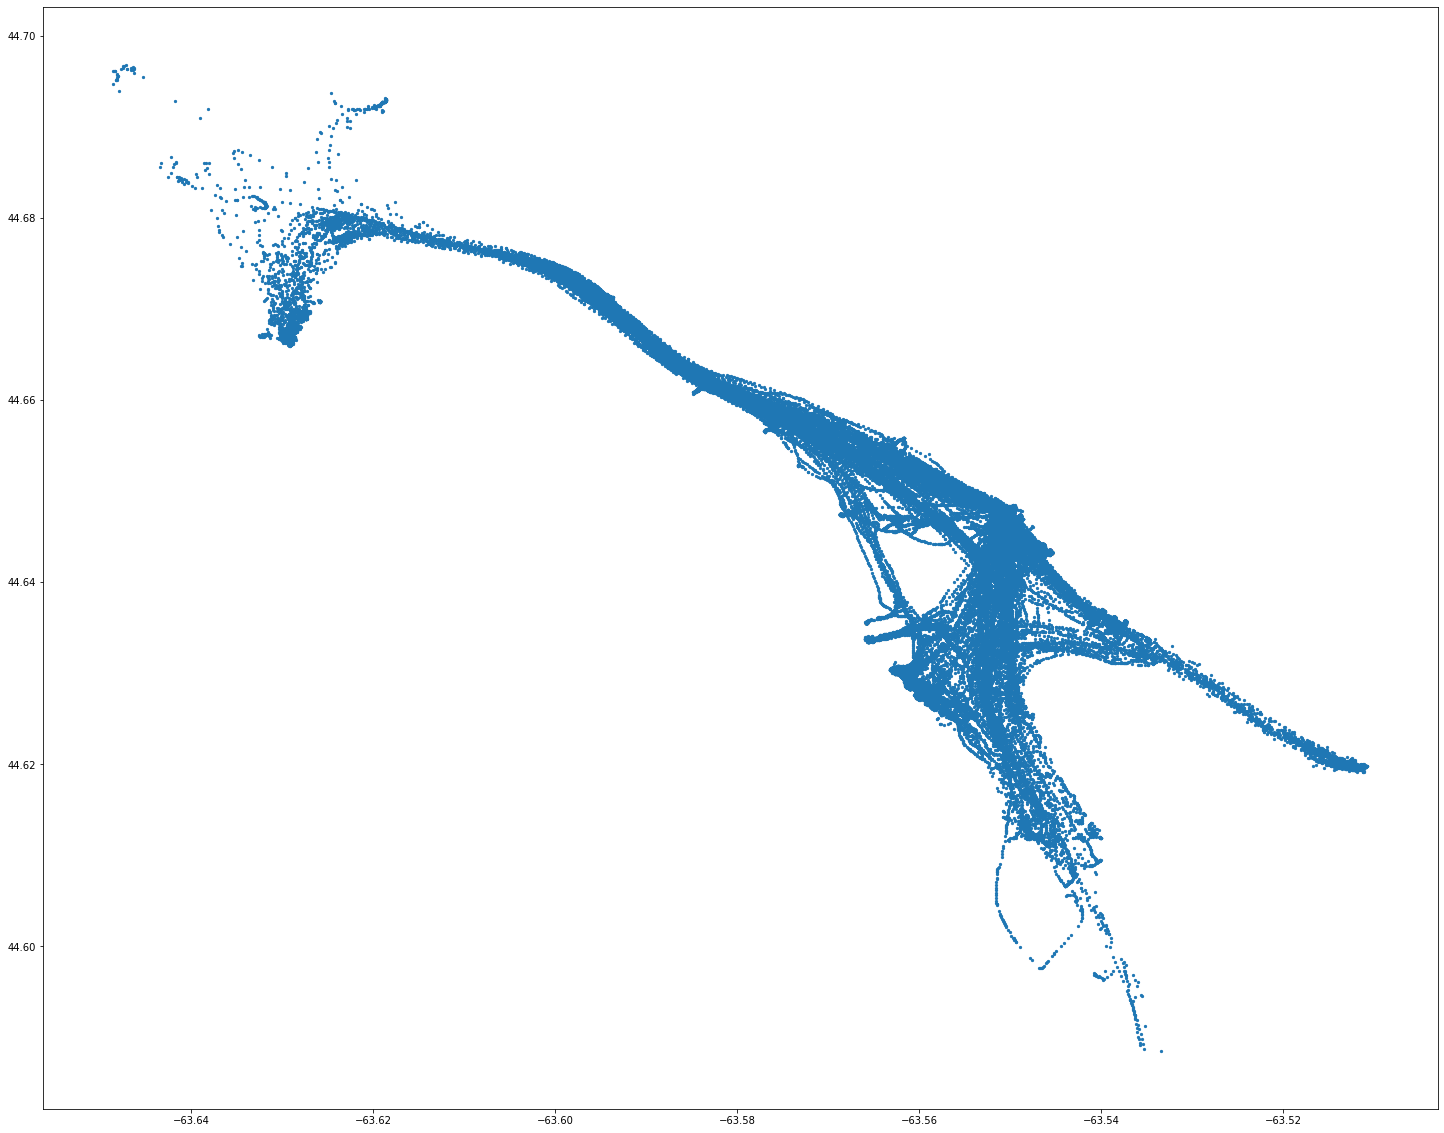

In [4]:
ax=gdf.plot(figsize=(25,25),markersize=5)

Analyzing the shapefile for Canadian ports

In [5]:
import fiona
import pprint
with fiona.open('/Users/gaganpree99/Desktop/DataScience/A3/Nima_Ports/assignment3shapefile.shp') as src:
    pprint.pprint(src[:3])

[{'geometry': {'coordinates': [[(-63.59160304069519, 44.664929225460696),
                                (-63.576014041900635, 44.656550145555364),
                                (-63.57622861862184, 44.65577169961185),
                                (-63.57893228530884, 44.65445900239159),
                                (-63.58354568481445, 44.65839700490685),
                                (-63.59281539916991, 44.66421193814845),
                                (-63.59160304069519, 44.664929225460696)]],
               'type': 'Polygon'},
  'id': '0',
  'properties': OrderedDict([('field_1', 0),
                             ('port_name', 'pointpolygon'),
                             ('size', 0.0)]),
  'type': 'Feature'},
 {'geometry': {'coordinates': [[(-63.569431, 44.649993),
                                (-63.56943966749199, 44.64981656914741),
                                (-63.56946558649528, 44.64964183742038),
                                (-63.56950850739569, 44.649

Ploting Canadian ports

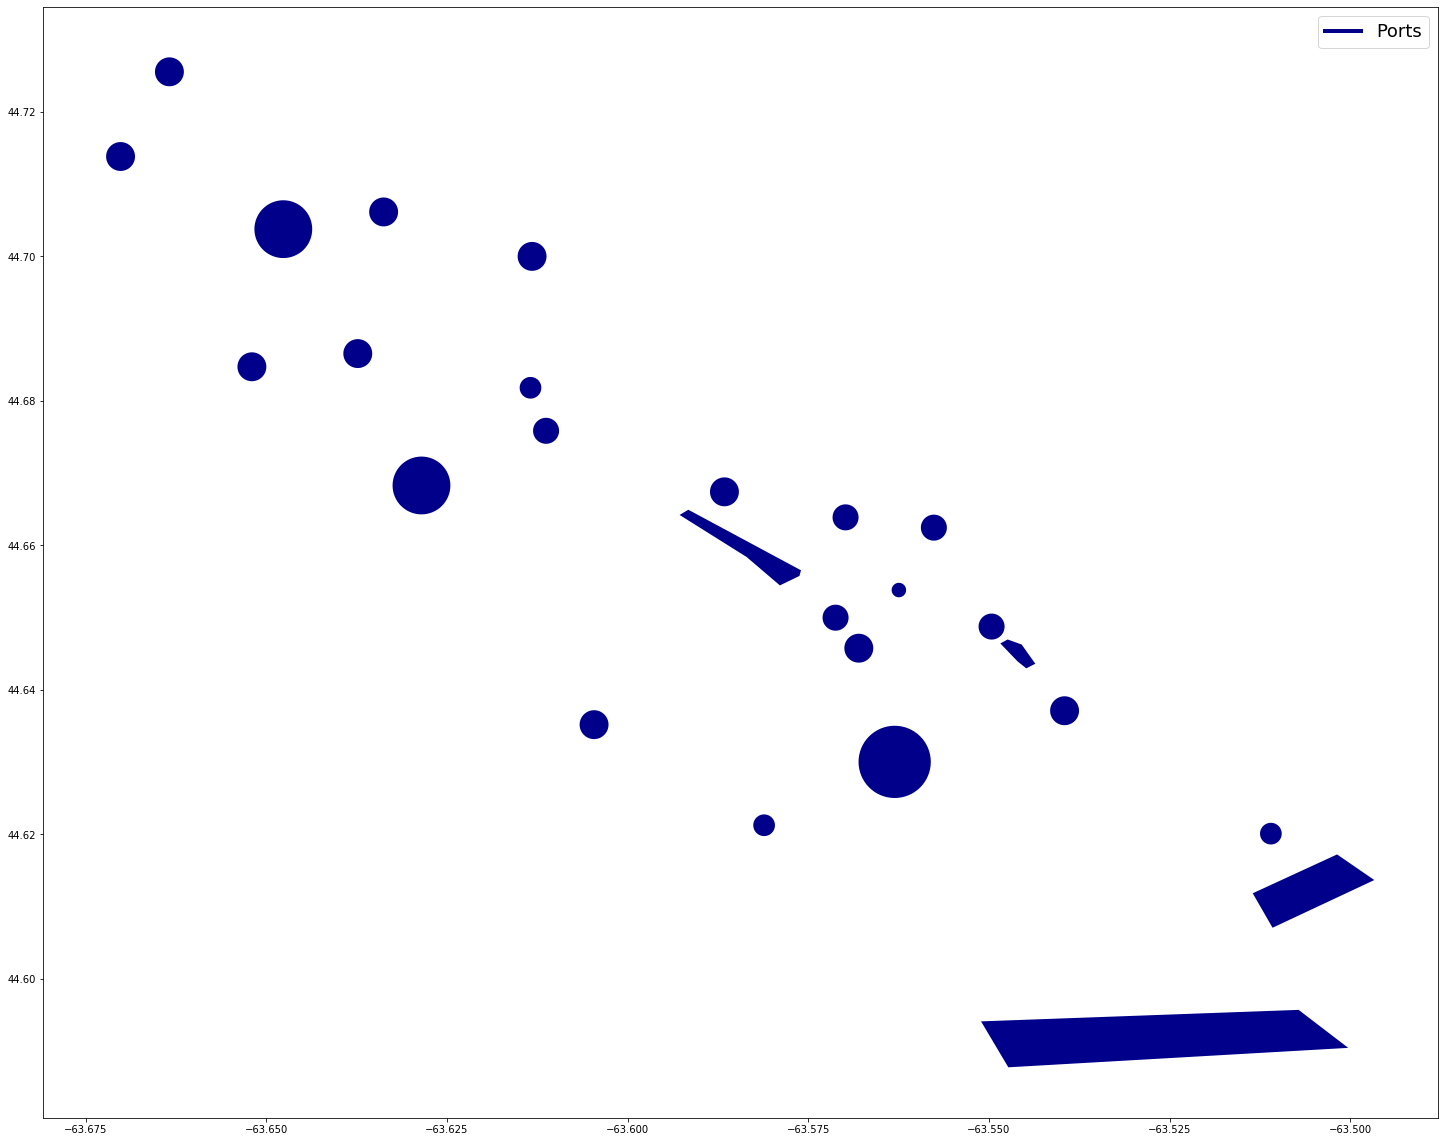

In [6]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

ports = gpd.read_file('/Users/gaganpree99/Desktop/DataScience/A3/Nima_Ports/assignment3shapefile.shp')
# ports.crs = {'init' :'epsg:4326'}
ports.crs = {'init': 'epsg:3006'}
byportName=ports.set_index(['port_name'])
ax=byportName.plot(figsize=(25,25),color='darkblue')

legend_elements = [Line2D([0], [0], color='darkblue', lw=4, label='Ports')]

ax.legend(handles=legend_elements,prop=dict(size=18))
plt.show()


---
## 1. Find all the vessels that visited ports in the provided shapefile.


In [7]:
centeroids = []
points = []

for x in ports['port_name']:
#   print(x)
    centeroids.append(byportName.loc[[x],:].centroid)
    
# # To create buffer around centeroids
# for center in centeroids:
#     p = center.geometry.buffer(0.005)
#     points.append(p[0])

# # To create buffer around shape of port
for shape in ports['port_name']:
    p = byportName.loc[[shape],:].geometry.buffer(0.001)
    points.append(p[0])

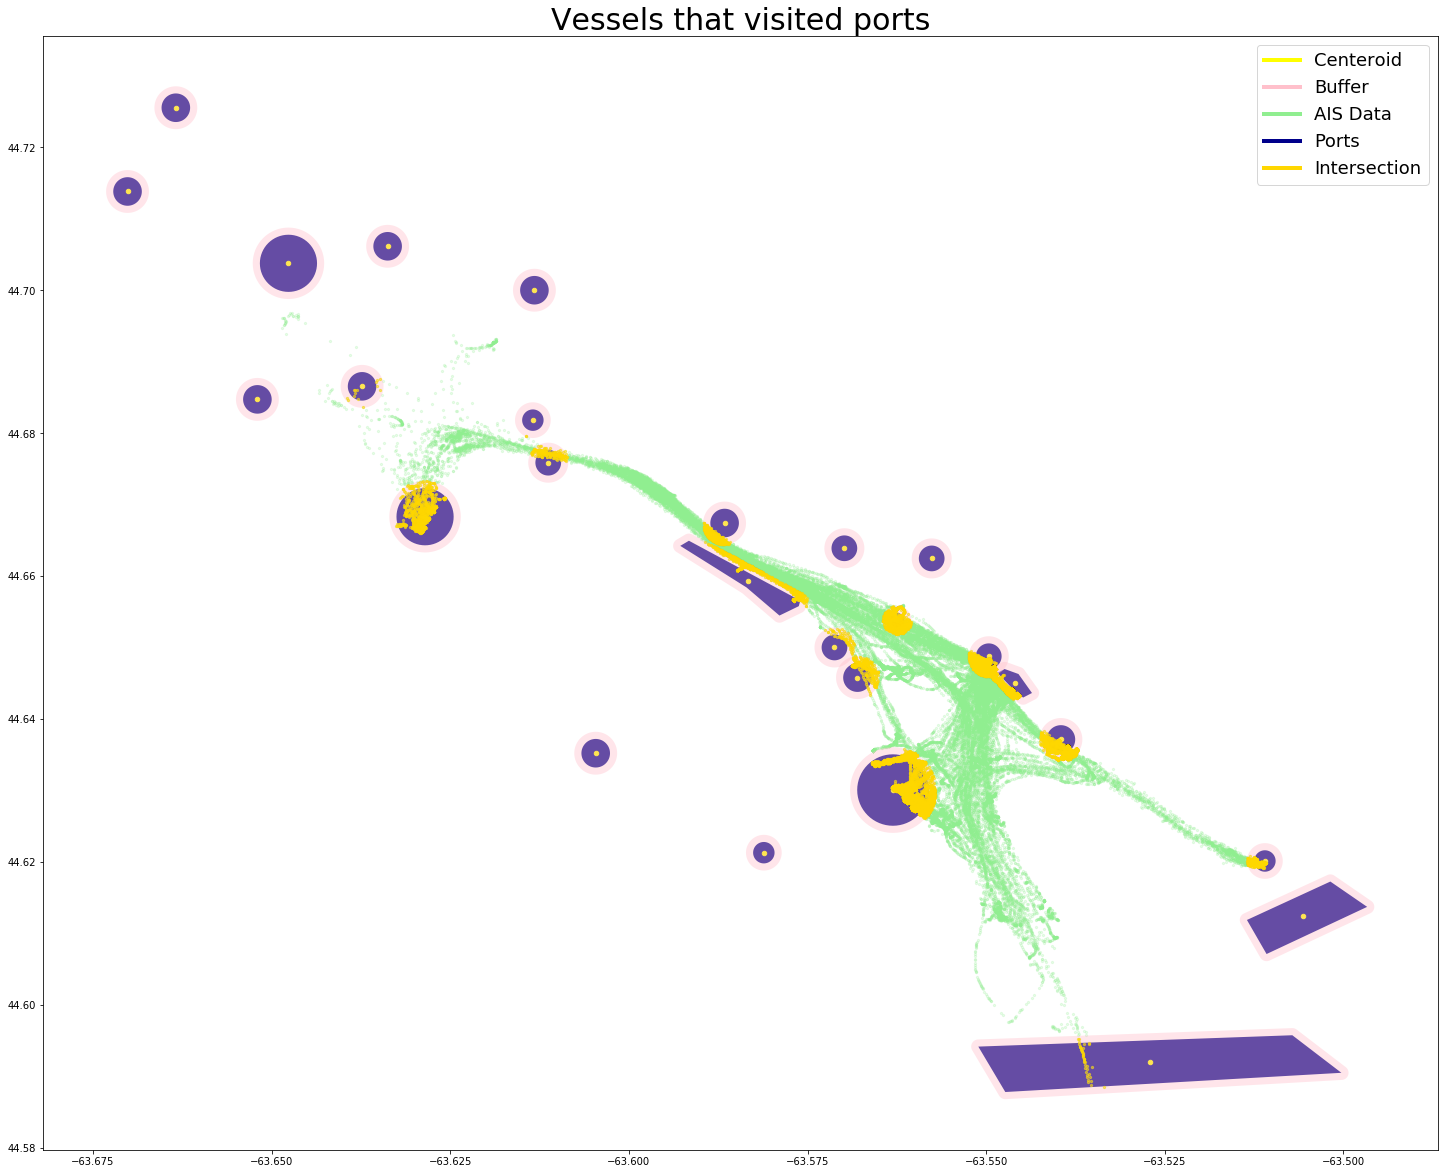

In [8]:
ax = byportName.loc[ports['port_name'],:].plot(color='darkblue', figsize=(25,25),markersize=5)

for center in centeroids:
    gpd.GeoSeries(center).plot(ax=ax, color='yellow', markersize=20)

gdf.plot(ax=ax, color='lightgreen', alpha=0.2, markersize=5)

for shape in points:    
    gpd.GeoSeries(shape).plot(ax=ax, color='pink', markersize=5, alpha = 0.4)
    gdf.loc[gdf.within(shape),:].plot(ax=ax, color='gold', markersize=5, alpha=0.5)

ax.set_title("Vessels that visited ports", fontdict={'fontsize': 30, 'fontweight': 'medium'})
legend_elements = [Line2D([0], [0], color='yellow', lw=4, label='Centeroid'),
                   Line2D([0], [0], color='pink', lw=4, label='Buffer'),
                   Line2D([0], [0], color='lightgreen', lw=4, label='AIS Data'),
                   Line2D([0], [0], color='darkblue', lw=4, label='Ports'),
                   Line2D([0], [0], color='gold', lw=4, label='Intersection')
                   ]

ax.legend(handles=legend_elements,prop=dict(size=18))
plt.show()

The graph shown above shows the intersection of AIS Data with ports in Gold color. A buffer of '0.001' is drawn around the shape of each port in pink color. 

---
## 2. Show the density of each port using a colour-coded map.

In [10]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

densityDataframe = gpd.GeoDataFrame(columns=["PortName", "Count", "Density", "geometry"])

for areaName in set(byportName.index.values):
    area=byportName.loc[byportName.index == areaName,:]
    bufferedArea=area.geometry.buffer(0.001)[0]
    intersections=gdf.loc[gdf.within(bufferedArea),:]
    count = intersections.shape[0]
    density = count/(gdf.shape[0])

    densityDataframe = densityDataframe.append({
        "PortName": areaName,
        "Count": count,
        "Density": density,
        "geometry": area.geometry[0]
    }, ignore_index=True)


Text(0.5, 1, 'Density coded map based on count')

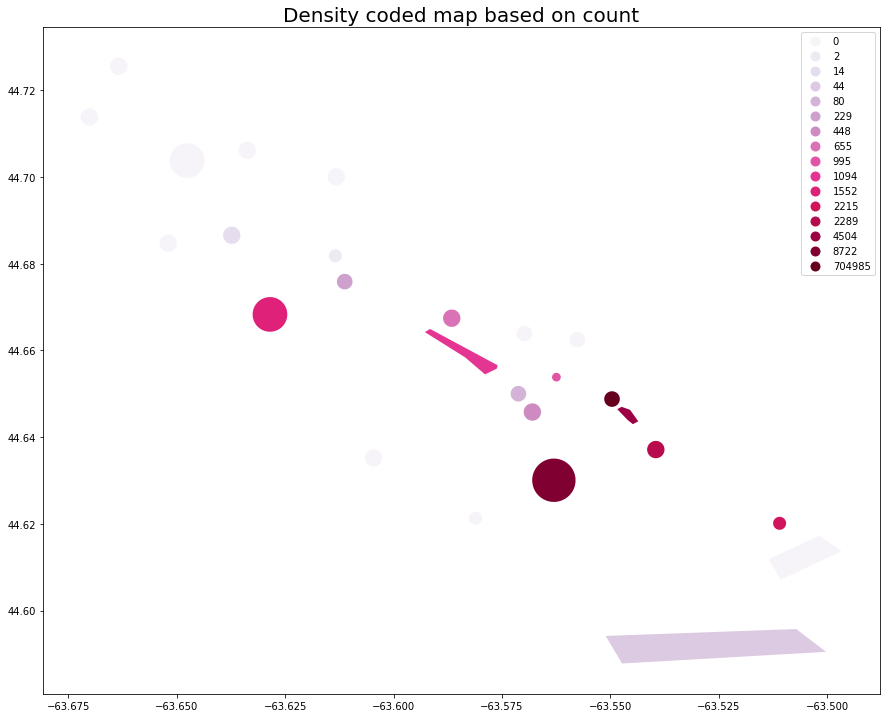

In [11]:
fig, ax = plt.subplots(1, figsize= (15,15))
densityDataframe.plot(ax = ax, column = 'Count', legend=True, cmap='PuRd',label='curve1')
ax.set_title("Density coded map based on count", fontdict={'fontsize': 20, 'fontweight': 'medium'})


The above plot shows the color coded map for the provided AIS dataset. 

As we can see from this plot, the density of the ports is in extreme ends. Either it is too low or it is too high. 

---
## 3. Now divide the AIS data into data frames with a one-hour interval. Repeat steps 1 and 2 forall of the sub-dataframes.

Splitting Data on hourly interval.

In [12]:
sortBasedOnTime = gdf.sort_values(by="event_time").reset_index(drop=True)

In [13]:
list = []
S = pd.to_datetime(sortBasedOnTime.event_time)
for i, g in sortBasedOnTime.groupby([(S - S[0]).astype('timedelta64[1h]')]):
        list.append(g.reset_index(drop=True))

A function to create Directory for storing plots


In [15]:
def createDirectory(output_path):
    import shutil, os
    try:
        shutil.rmtree(output_path)
        os.mkdir(output_path)
    except OSError:
        os.mkdir(output_path)
        print ("Successfully created the directory %s " % output_path)
    else:
        print ("Successfully created the directory %s " % output_path)



---

Repeating Question 1 on the new dataset created. The plots for this have been saved into 'maps_1/' directory.

In [16]:
output_path = 'maps_1'
createDirectory(output_path)

filenames = []
count = 0
for data in list:
    
    ax=byportName.loc[ports['port_name'],:].plot(figsize=(15,15))
    fig=data.plot(ax=ax, color='lightgreen', markersize=5)
    
    for center in centeroids:
        gpd.GeoSeries(center).plot(ax=ax, color='yellow', markersize=20)

    for shape in points:    
        gpd.GeoSeries(shape).plot(ax=ax, color='pink', markersize=5, alpha = 0.4)
        data.loc[data.within(shape),:].plot(ax=ax, color='gold', markersize=5, alpha=0.5)

    
    legend_elements = [Line2D([0], [0], color='yellow', lw=4, label='Centeroid'),
                   Line2D([0], [0], color='pink', lw=4, label='Buffer'),
                   Line2D([0], [0], color='lightgreen', lw=4, label='AIS Data'),
                   Line2D([0], [0], color='darkblue', lw=4, label='Ports'),
                   Line2D([0], [0], color='gold', lw=4, label='Intersection')
                   ]

    ax.legend(handles=legend_elements,prop=dict(size=18))
    
    # add a title
    fig.set_title('Vessels that visited ports per hour', \
              fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filenames.append(str(count) +'.jpg')
    filepath = os.path.join(output_path, filenames[count])
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=75)
    count = count + 1
    plt.close("all")

Successfully created the directory maps_1 


---

Repeating Question 2 on the new dataset created. The plots for this have been saved into 'maps_2/' directory.

In [17]:
output_path = 'maps_2'
createDirectory(output_path)

filenames = []
temp = 0
for data in list:
    densityTemp = gpd.GeoDataFrame(columns=["PortName", "Count", "Density", "geometry"])

    ax=byportName.loc[ports['port_name'],:].plot(color='black', figsize=(15,15))
    for areaName in set(byportName.index.values):
        area=byportName.loc[byportName.index == areaName,:]
        bufferedArea=area.geometry.buffer(0.001)[0]
        intersections=data.loc[data.within(bufferedArea),:]
        count = intersections.shape[0]
        density = count*1.0/gdf.shape[0]
        
        densityTemp = densityTemp.append({
            "PortName": areaName,
            "Count": count,
            "Density": density,
            "geometry": area.geometry[0]
        }, ignore_index=True)
        
    fig = densityTemp.plot(ax = ax, column = 'Count', legend=True, cmap='Paired')

    
    # add a title
    fig.set_title('Density Coded Map/hour', \
              fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filenames.append(str(temp) +'.jpg')
    filepath = os.path.join(output_path, filenames[temp])
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=75)
    temp = temp + 1
    plt.close("all")

Successfully created the directory maps_2 


---

Function to create animation for the created plots:

In [22]:
from os import listdir
from os.path import isfile, join
import imageio, os

def creatAnimation(output_path):
    onlyfiles = [f for f in listdir(output_path) if isfile(join(output_path, f))]
    images = []
    for filename in onlyfiles:
        filepath = os.path.join(output_path, filename)
        images.append(imageio.imread(filepath))
    pathName = os.path.join(output_path + "/movie.gif")
    imageio.mimsave(pathName, images)


In [23]:
creatAnimation("maps_1")
creatAnimation("maps_2")






| Animation for Q1 | Animation for Q2 |
|--|--|
| ![Animation for Q1](maps_1/movie.gif "Animation for Q1") | ![Animation for Q2](maps_2/movie.gif "Animation for Q2") |




The animations for both Question 1 and Question 2 are shown in the figure above. The first part shows the Vessels visiting the ports in 1 hour interval and the second part shows the Density Coded map for the same interval.


NOTE: If you are not able to visualize the animations in this file. You can directly navigate to the folder `maps_1` and `maps_2` and check the `movie.gif` file there.

or You can download the animations from [GitLab: maps_1/movie.gif](https://git.cs.dal.ca/singh1/a3-data-science/blob/master/maps_1/movie.gif) and [GitLab: maps_2/movie.gif](https://git.cs.dal.ca/singh1/a3-data-science/blob/master/maps_2/movie.gif)


---

## 4. Select any port you like. Create a temporal chart for the density of messages in that port.

The port we have selected is 'oulier_maybecday'.

The following code plots the temporal chart for the density of port at a specific hour.

<IPython.core.display.Javascript object>


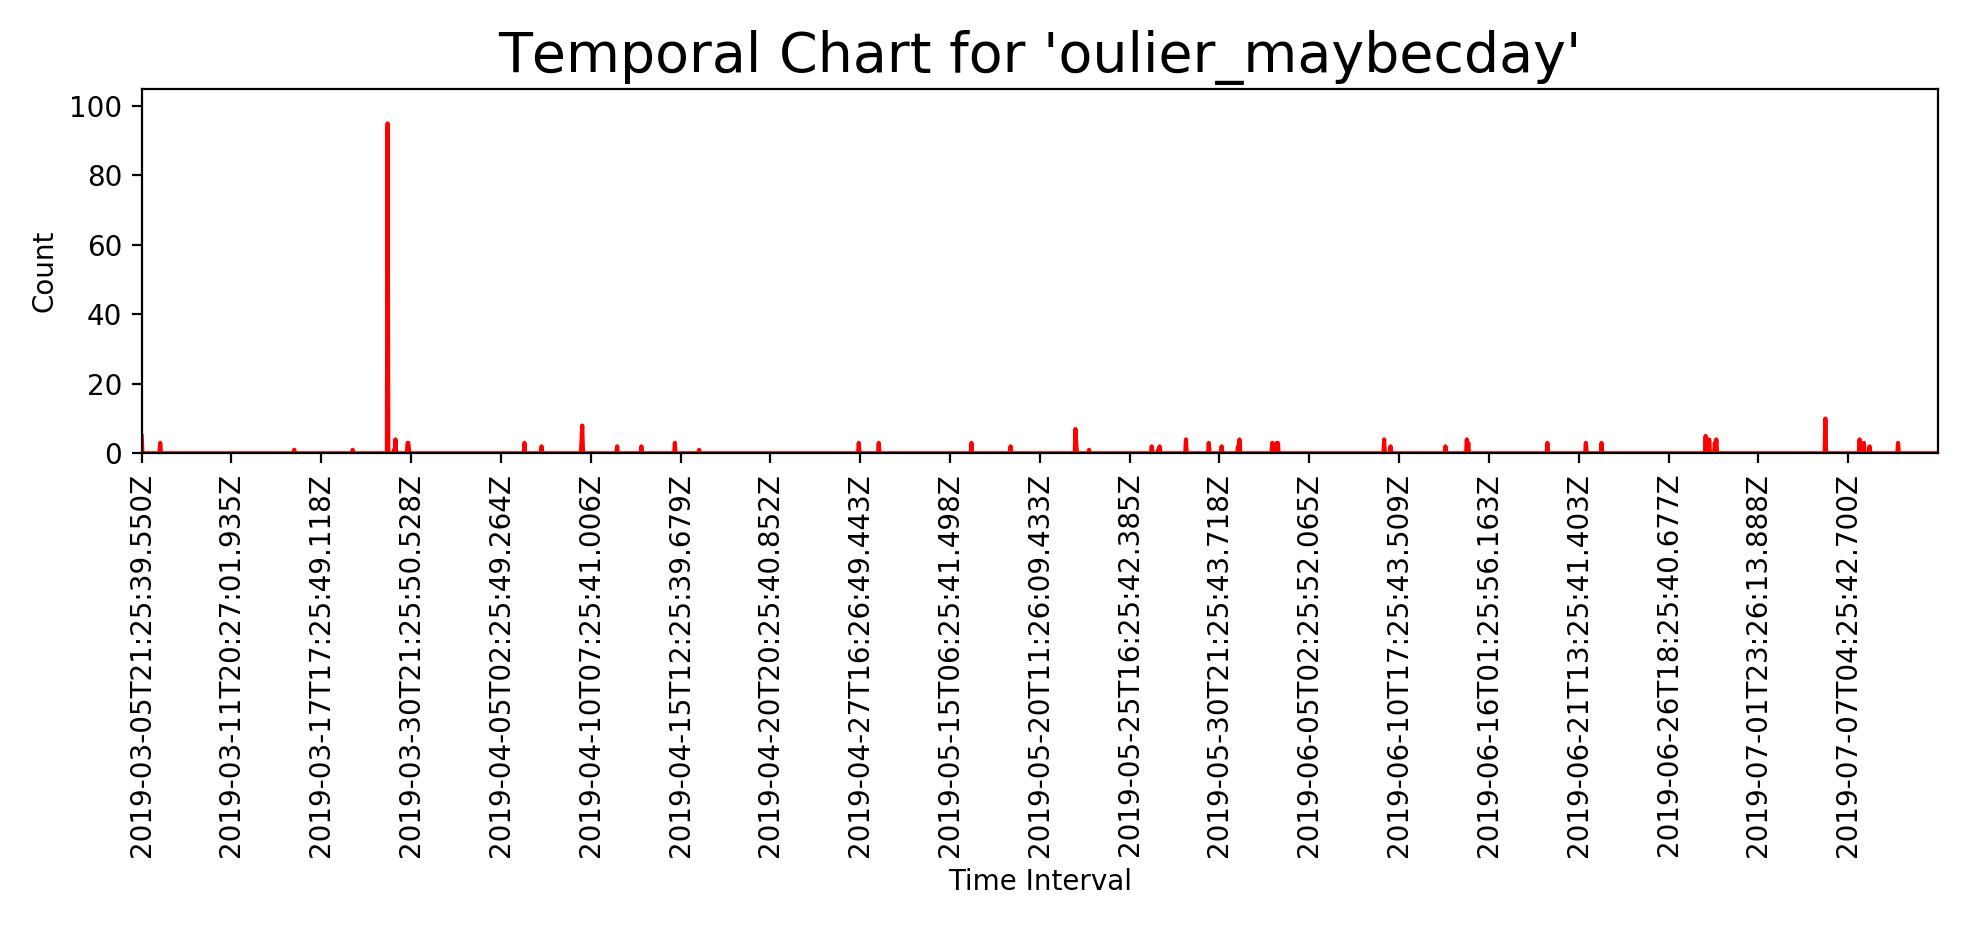

(None,)

In [41]:
from matplotlib import rcParams
import time
rcParams.update({'figure.autolayout': True})
%matplotlib notebook

xdata = []
xlabel = []
ydata = []
plt.show()
 
axes = plt.gca()

axes.set_xlim(0, len(list))


line, = axes.plot(xdata, ydata, 'r-')
# plt.figure(figsize=(9,5))


areaName = 'oulier_maybecday'
area = byportName.loc[byportName.index == areaName,:]
aa=area.centroid.geometry.buffer(0.001)[0]  
t  = 0

for timeInterval in list:
    r=timeInterval.loc[timeInterval.within(aa),:]
    count = r.shape[0]   
    if count > 0:
        density = count*1.0/timeInterval.shape[0]        
    else:
        density = 0
    
    xdata.append(t)
    ydata.append(count)
    line.set_xdata(xdata)
    line.set_ydata(ydata)
    
    if ((t%(125)) == 0):
        xlabel.append(timeInterval['event_time'][0])
        
    plt.draw()
    plt.pause(1e-17)
    time.sleep(0.1)
    #print(areaName,timeInterval['event_time'][0], count, density)
    t = t + 1

axes.set_ylim(0,max(ydata)+10)
plt.xticks(xdata, xlabel, rotation=90)
plt.title("Temporal Chart for 'oulier_maybecday'", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.locator_params(axis='x', tight=True, nbins=20)
plt.xlabel('Time Interval')
plt.ylabel('Count')
plt.show(),

The above plot shows the temporal chart for port 'oulier_maybecday'.

We can zoom-in to study the plots in details.

---

## 5. Use concept drift methods on step 4 and find out if there is any drift in the data that can be detected.

***a. Adaptive Windowing method for concept drift detection (ADWIN)***

In [144]:
from skmultiflow.drift_detection.adwin import ADWIN
adwin = ADWIN(delta=5)

for i in range(len(ydata)):
    adwin.add_element(ydata[i])
    if adwin.detected_change():
        print('Change detected in data: ' + str(ydata[i]) + ', at: ' + str(list[i]['event_time'][0]))

Change detected in data: 0, at: 2019-03-09T06:25:58.744Z
Change detected in data: 0, at: 2019-03-31T05:25:40.688Z


Even after changing the value of input parameter i.e. `delta` we are not able to see the drifts as expected from temporal chart plotted in previous question.

***b. Drift Detection Method (DDM)***

In [127]:
from skmultiflow.drift_detection import DDM
ddm = DDM(min_num_instances=15, warning_level=2.0, out_control_level=4.0)

for i in range(len(ydata)):
    ddm.add_element(ydata[i])
#     if ddm.detected_warning_zone():
#         print('Warning zone has been detected in data: ' + str(ydata[i]) + ', at: ' + str(list[i]['event_time'][0]))
    if ddm.detected_change():
        print('Change has been detected in data: ' + str(ydata[i]) + ', at: ' + str(list[i]['event_time'][0]))

Change has been detected in data: 95, at: 2019-03-29T15:25:39.701Z
Change has been detected in data: 1, at: 2019-03-30T21:25:50.528Z
Change has been detected in data: 3, at: 2019-04-06T15:28:00.286Z
Change has been detected in data: 2, at: 2019-04-07T15:25:40.206Z
Change has been detected in data: 3, at: 2019-04-09T23:25:40.686Z
Change has been detected in data: 4, at: 2019-06-01T13:26:23.460Z
Change has been detected in data: 3, at: 2019-06-03T11:26:13.665Z


In DDM, on tweaking the values of input parameters we could see the drifts that can be verified through the temporal chart shown in question 4.

Hence, DDM gives the desired results.


***c. Early Drift Detection Method (EDDM)***

In [106]:
from skmultiflow.drift_detection import EDDM
eddm = EDDM()

for i in range(len(ydata)):
    eddm.add_element(ydata[i])
    if eddm.detected_warning_zone():
        print('Warning zone has been detected in data: ' + str(ydata[i]) + ' - of index: ' + str(i))
    if eddm.detected_change():
        print('Change has been detected in data: ' + str(ydata[i]) + ' - of index: ' + str(i))

EDDM detects no change on the datastream. Also, there are no input parameters that can be tweaked to get desired results.

***d. Page-Hinkley method for concept drift detection***

In [123]:
from skmultiflow.drift_detection import PageHinkley
ph = PageHinkley(min_instances=15, delta=0.005, threshold=10, alpha=0.9999)

for i in range(len(ydata)):
    ph.add_element(ydata[i])
    if ph.detected_change():
        print('Change has been detected in data: ' + str(ydata[i]) + ' - of index: ' + str(list[i]['event_time'][0]))

Change has been detected in data: 95 - of index: 2019-03-29T15:25:39.701Z
Change has been detected in data: 8 - of index: 2019-04-10T00:30:48.105Z
Change has been detected in data: 1 - of index: 2019-05-23T18:25:42.865Z
Change has been detected in data: 4 - of index: 2019-06-01T13:26:23.460Z
Change has been detected in data: 3 - of index: 2019-06-30T04:25:41.876Z
Change has been detected in data: 3 - of index: 2019-07-08T21:26:32.642Z


On tuning the input parameters for Page-Hinkley method, we get the drifts that can be verified through temporal chart plotted in question 4.

---

After executing all the methods for drift detection, we observed that `Drift Detection Method` and `Page-Hinkley Method` are suitable for our use case as they are able to detect the Drifts in the given data stream. 

However, if we were to compare the above 2 methods, `Drift Detection Method` has an upper edge over `Page-Hinkley Method` as it can detect warnings as well, which is not possible in case of `Page-Hinkley Method`.

---

## 6. Cluster the ports based on their message density using DBSCAN and categorize the ports based on traffic (message density).

The following code implements the DBSCAN algorithm based on AIS message density. We have tweaked the input parameters to get optimum results.


The value of `eps` has been set to 600 and the values of `min_samples` has been set to 2.

In [87]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=600, min_samples=2).fit(densityDataframe[['Count']])
clustering

DBSCAN(algorithm='auto', eps=600, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

Finding the number of clusters created.

In [88]:
num_clusters = len(set(clustering.labels_))
num_clusters


3

Finding the Labels for the ports and assigning them to the dataframe.

In [89]:
cluster_labels = clustering.labels_
cluster_labels


array([ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1, -1,  0,  1,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0])

In [90]:
densityDataframe['DBSCANlabel'] = cluster_labels

Let us have a look at the geodataframe that has the `DBSCANlabel` for each port:

In [141]:
densityDataframe

,PortName,Count,Density,geometry,DBSCANlabel
0,port1,80,0.000104,"POLYGON ((-63.569431 44.649993, -63.5694396674...",0
1,po002,2,0.000003,"POLYGON ((-63.611943 44.681805, -63.6119502229...",0
2,NN Jetty,0,0.000000,"POLYGON ((-63.631767 44.706138, -63.6317766305...",0
3,pp,0,0.000000,"POLYGON ((-63.66140799999999 44.725527, -63.66...",0
4,p009,0,0.000000,"POLYGON ((-63.64999499999999 44.684713, -63.65...",0
5,enter2,0,0.000000,POLYGON ((-63.50183486938477 44.61723320107161...,0
6,port2,229,0.000299,"POLYGON ((-63.60949000000001 44.675853, -63.60...",0
7,southend container terminal,8722,0.011376,"POLYGON ((-63.55805200000001 44.63004, -63.558...",-1
8,port6,0,0.000000,"POLYGON ((-63.555828 44.662453, -63.5558366674...",0
9,plll,0,0.000000,"POLYGON ((-63.579618 44.621272, -63.5796252229...",0


Lets plot these clusters:

<IPython.core.display.Javascript object>


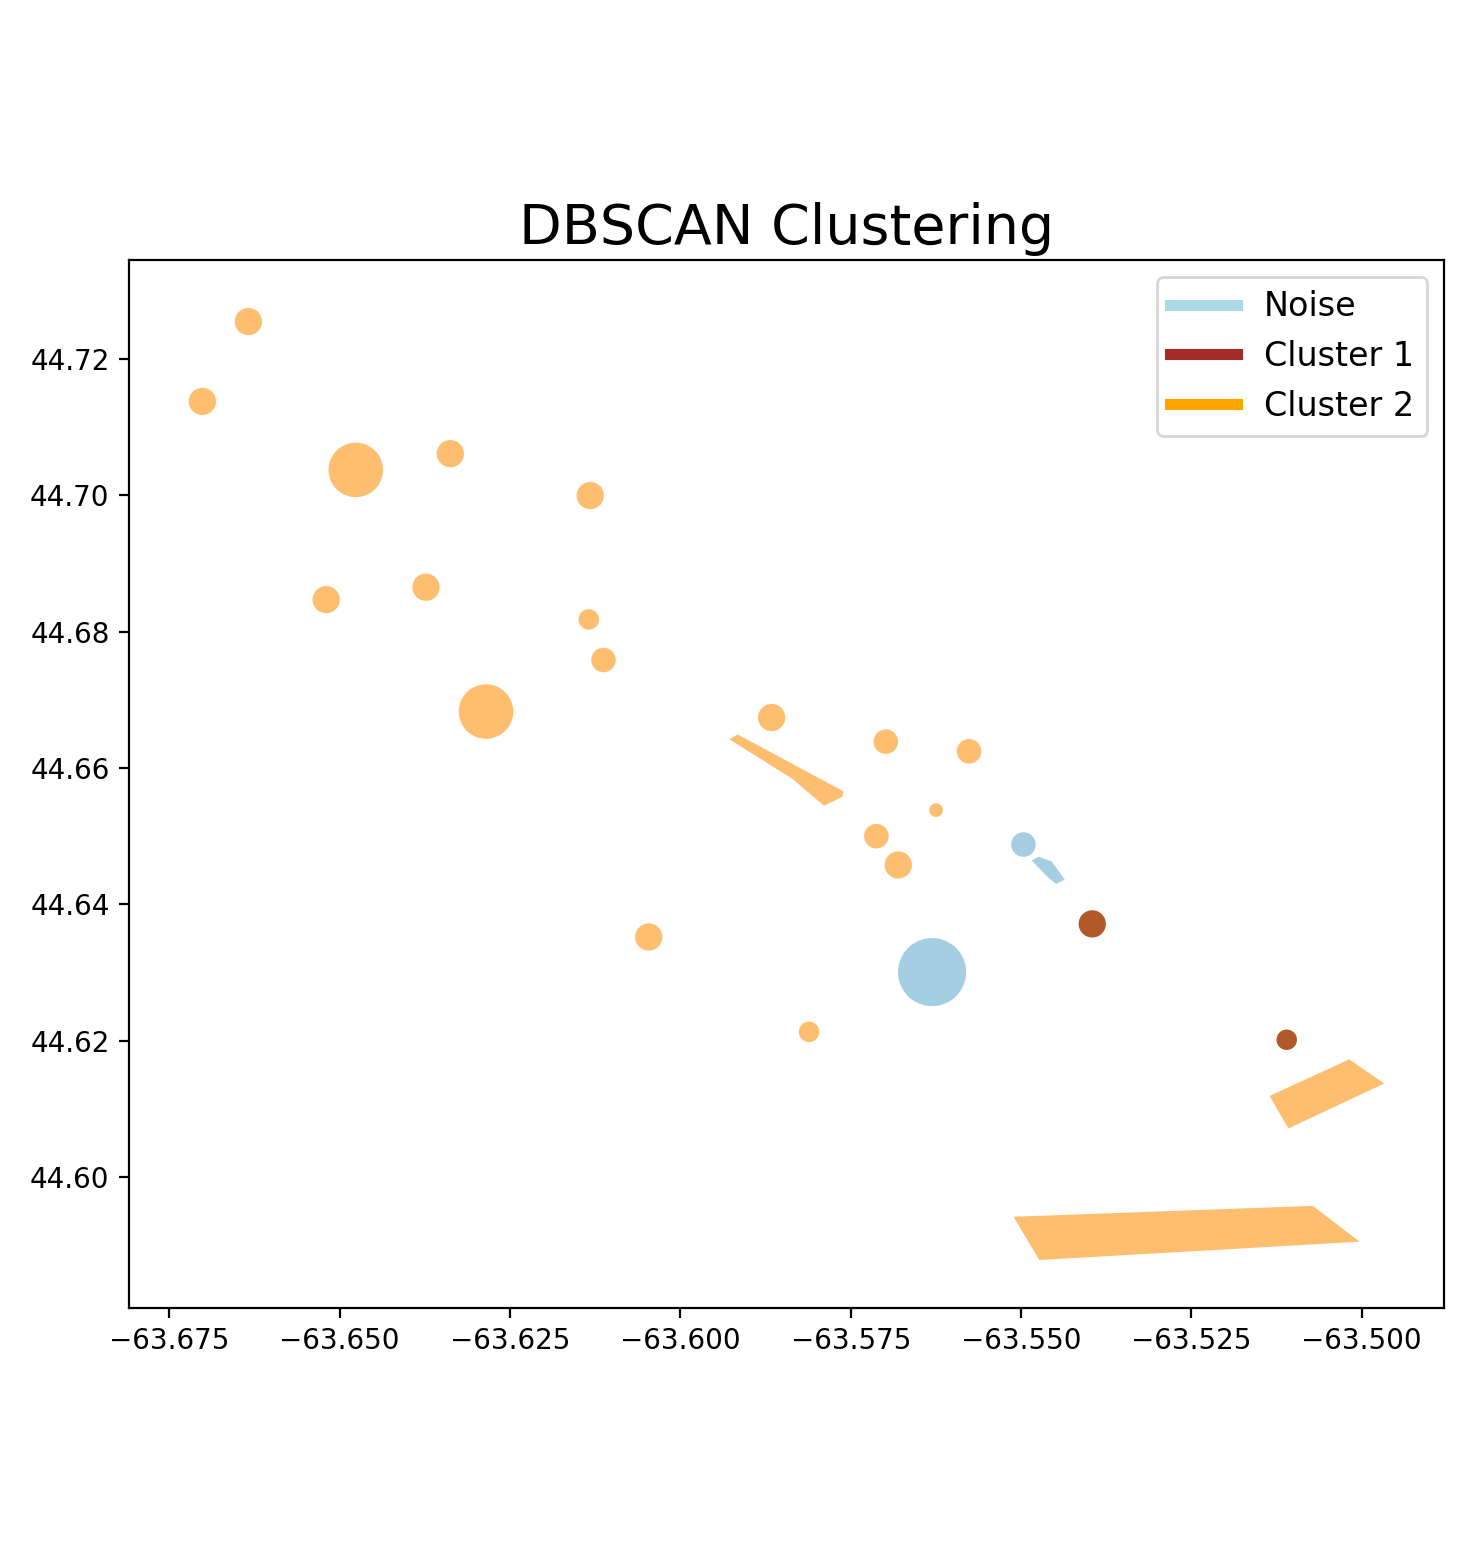

In [140]:
fig, ax = plt.subplots(1, figsize= (10,10))
densityDataframe.plot(ax = ax, column = 'DBSCANlabel', cmap='Paired')
ax.set_title("DBSCAN Clustering", fontdict={'fontsize': 20, 'fontweight': 'medium'})
legend_elements = [
                   Line2D([0], [0], color='lightblue', lw=4, label='Noise'),
                   Line2D([0], [0], color='brown', lw=4, label='Cluster 1'),
                   Line2D([0], [0], color='orange', lw=4, label='Cluster 2')
                   ]

ax.legend(handles=legend_elements,prop=dict(size=12))

The above plot shows the clusters created using DBSCAN based on the AIS message density. The ports have been classified into 2 categories as shown in figure.

3 of the ports have been classified as noise.

---

# References

1. skmultiflow.drift_detection.adwin module — scikit-multiflow 0.1.4 documentation. (2019). Retrieved 5 August 2019, from https://scikit-multiflow.github.io/scikit-multiflow/skmultiflow.drift_detection.adwin.html

2. Matplotlib: Python plotting — Matplotlib 3.1.1 documentation. (2019). Retrieved 5 August 2019, from https://matplotlib.org/

3. GeoPandas 0.5.1 — GeoPandas 0.5.1 documentation. (2019). Retrieved 5 August 2019, from http://geopandas.org/

4. Python Data Analysis Library — pandas: Python Data Analysis Library. (2019). Retrieved 5 August 2019, from https://pandas.pydata.org/